In [7]:
# imports
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np                  
import seaborn as sns               

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import os                           
import datetime                    

import folium
from folium.plugins import HeatMap

# Airbnb

## Load Dataset

In [8]:
import pandas as pd

def extract_numeric_rating(rating):
    if rating is None:
        return None  # Handle missing values
    try:
        return float(rating.split('★')[0])  # Extract number before '*'
    except ValueError:
        return None  # Handle cases where rating doesn't follow the format

def process_and_display_data(file_paths):
    # Loading and displaying the first few rows of each file to understand their structure
    dataframes = []

    for file in file_paths:
        temp_df = pd.read_csv("/Users/ameygurunathparab/Desktop/IDMP/dataset/" + file)
        temp_df["city"] = file.split("_")[1]
        temp_df["state"] = file.split("_")[2].split(".")[0]
        dataframes.append(temp_df)

     
    # df_head = [df.head() for df in dataframes]

    # Merging all the datasets into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)

    combined_df['is_canceled'] = ((combined_df['minimum_nights'] > 30) & 
                                (combined_df['availability_365'] < 30) & 
                                (combined_df['number_of_reviews_ltm'] <= 1)).astype(int)

    column_to_split = "name"
    delimiter = " · "  # Modify this if your delimiter is different

    # Define names for the new columns (modify as needed)
    new_column_names = ["listing_name", "rating", "unit_type", "no_of_beds","no_of_baths"]

    # Split the column and expand into separate columns with names
    split_data = combined_df[column_to_split].str.split(delimiter, expand=True).rename(
        columns=dict(zip(range(len(new_column_names)), new_column_names))
    )


    # Apply the function to the 'rating' column
    # split_data['rating'] = split_data['rating'].apply(extract_numeric_rating)
    # split_data

    # Drop the original column (optional)
    # df.drop(column_to_split, axis=1, inplace=True)

    # Concatenate the original DataFrame (without the split column) with the split data
    combined_df = pd.concat([combined_df.drop(column_to_split, axis=1), split_data], axis=1)

   
    # Displaying the first few rows of the updated DataFrame
    print(combined_df)
    return combined_df

# Define file paths
file_paths_east = ["listings_boston_MA.csv","listings_cambridge_MA.csv","listings_jerseycity_NJ.csv","listings_newyorkcity_NY.csv","listings_rhodeisland_RI.csv","listings_washington_DC.csv"]

region_name_east = "East"

file_paths_central = ["listings_austin_TX.csv", "listings_chicago_IL.csv","listings_columbus_OH.csv","listings_dallas_TX.csv","listings_twincities_MS.csv"]
region_name_central = "Central"

file_paths_west = ["listings_denver_CO.csv","listings_hawaii_H.csv","listings_losangeles_CA.csv", "listings_oakland_CA.csv","listings_sandiego_CA.csv", 
                   "listings_sanfransisco_CA.csv","listings_seattle_WA.csv"]
region_name_west = "West"


# Process and display data for the USA
combined_df_east = process_and_display_data(file_paths_east)

# Process and display data for the USA
combined_df_west = process_and_display_data(file_paths_west)

# Process and display data for the USA
combined_df_central = process_and_display_data(file_paths_central)

# print(combined_df_central['is_canceled'] > 0)



                        id    host_id         host_name neighbourhood_group  \
0                     3781       4804             Frank                 NaN   
1                     5506       8229             Terry                 NaN   
2                     6695       8229             Terry                 NaN   
3                     8789      26988              Anne                 NaN   
4                    10813      38997          Michelle                 NaN   
...                    ...        ...               ...                 ...   
57889  1047064894296117631  107434423        Blueground                 NaN   
57890  1047730533367174366  437660791  Eddie-HostelChic                 NaN   
57891  1047772826607759074  437660791  Eddie-HostelChic                 NaN   
57892  1047777612294831826  437660791  Eddie-HostelChic                 NaN   
57893  1047931080098470138  350603487           Stephen                 NaN   

                                        neighbourho

In [9]:
import pandas as pd
import numpy as np


def remove_outliers(df):
    # Define threshold for outliers (e.g., 3 standard deviations)
    z_threshold = 1

    # Calculate z-scores
    df['z_score'] = (df['price'] - df['price'].median()) / df['price'].std()

    # Identify outliers based on z-scores
    outliers = df[np.abs(df['z_score']) > z_threshold]

    # Filter data excluding outliers
    filtered_df = df[~df['price'].isin(outliers['price'])]

    # Print original and filtered DataFrames
    print("Original DataFrame:")
    print(df.size)
    print("\nDataFrame after removing outliers:")
    print(filtered_df.size)
    return filtered_df


filtered_east = remove_outliers(combined_df_east)
filtered_central = remove_outliers(combined_df_central)
filtered_west = remove_outliers(combined_df_west)

Original DataFrame:
1505244

DataFrame after removing outliers:
1486940
Original DataFrame:
976326

DataFrame after removing outliers:
954694
Original DataFrame:
3001076

DataFrame after removing outliers:
2919176


/var/folders/9q/blxc_lsn4jx36jwwb41zb6ch0000gn/T/ipykernel_2407/3664482889.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].apply(clean_rating)


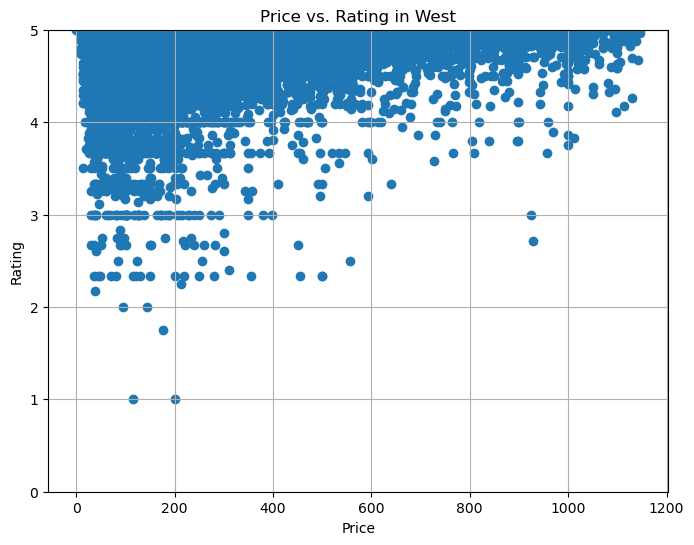

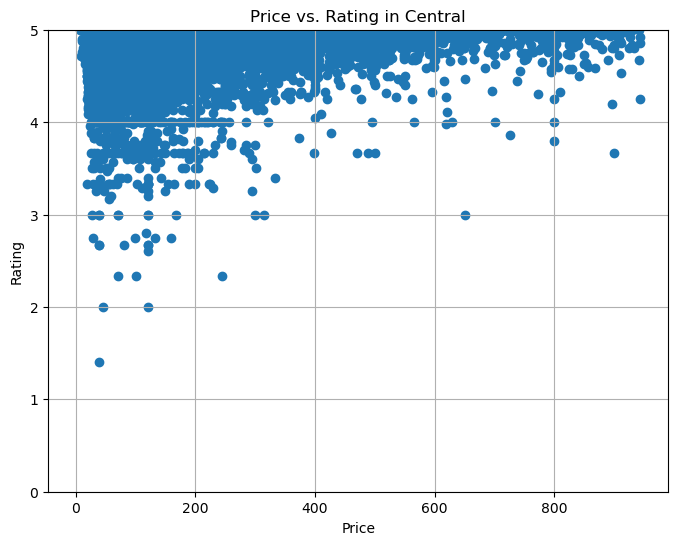

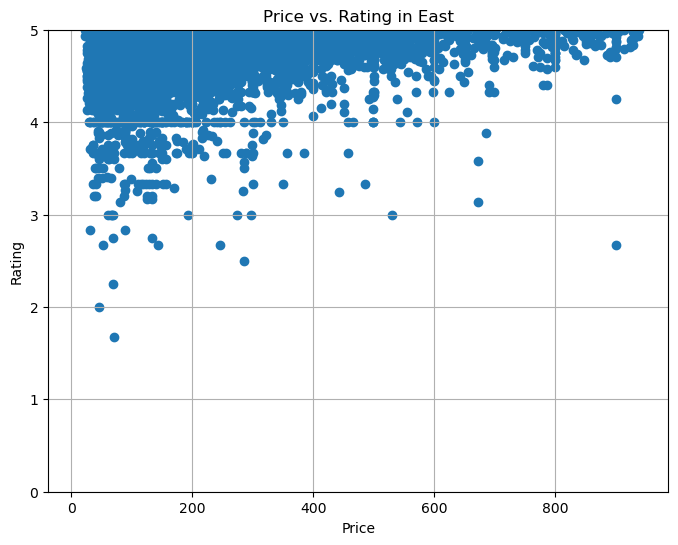

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your map is a dictionary where keys are region names and values are DataFrames
# containing 'rating' (float) and 'price' (int) columns
def to_float_with_coerce(x):
    if x is None:
       return np.nan  # Use numpy.nan for consistent missing value representation
    try:
      return float(x.strip('★'))
    except AttributeError or ValueError:
      return np.nan  # Use numpy.nan for consistent missing value representation
    
def clean_rating(rating):
  if pd.isna(rating):  # Check for missing values (including None)
    return np.nan
  else:
    try:
      # Attempt to convert the rating to float first (without stripping)
      try:
          return float(rating)
      except ValueError:
          # If conversion fails, strip the star and then convert to float
          rating = rating.strip('★')
          return float(rating)
    except ValueError:
      # If any conversion fails, return NaN
      return np.nan
    
def convert_rating(df):
    df['rating'] = df['rating'].apply(clean_rating)
    #print(df['rating'])

def analyze_price_vs_rating(df,region):
    # Assuming your DataFrame is named 'df' and has columns named 'price' (int) and 'rating' (float)

    temp_df_price = df['price'].fillna(df['price'].median())
    temp_df_rating = df['rating'].fillna(df['price'].median())
    # Create the scatter plot
    plt.figure(figsize=(8, 6))  # Adjust figure size as desired
    plt.scatter(temp_df_price, temp_df_rating)

    # Set labels and title
    plt.xlabel('Price')
    plt.ylim(0,5)
    plt.ylabel('Rating')
    plt.title(f'Price vs. Rating in {region}')

    # Add grid for better readability (optional)
    plt.grid(True)

    plt.show()

convert_rating(filtered_central)
convert_rating(filtered_east)
convert_rating(filtered_west)

analyze_price_vs_rating(filtered_west,'West')
analyze_price_vs_rating(filtered_central,'Central')
analyze_price_vs_rating(filtered_east,'East')


Key Metrics for Comparative Analysis:

Average Price: Compare the average listing price in each country.

Room Types: Analyze the distribution of room types (like entire home, private room, shared room).

Number of Reviews: Compare the average number of reviews per listing.

Availability: Assess the average availability days in a year for listings.

Seasonal Trends: If data is available, compare peak and off-peak seasons.

## Analyzing Data

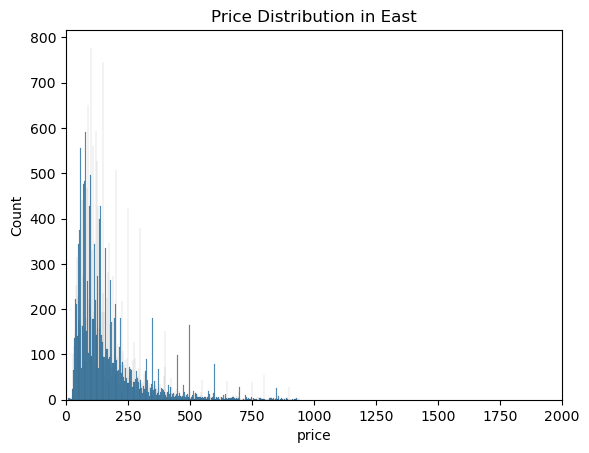

Accuracy in East: 0.7745239658568615


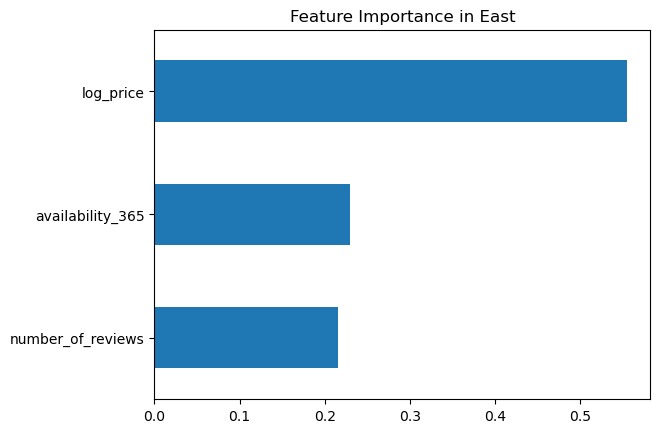

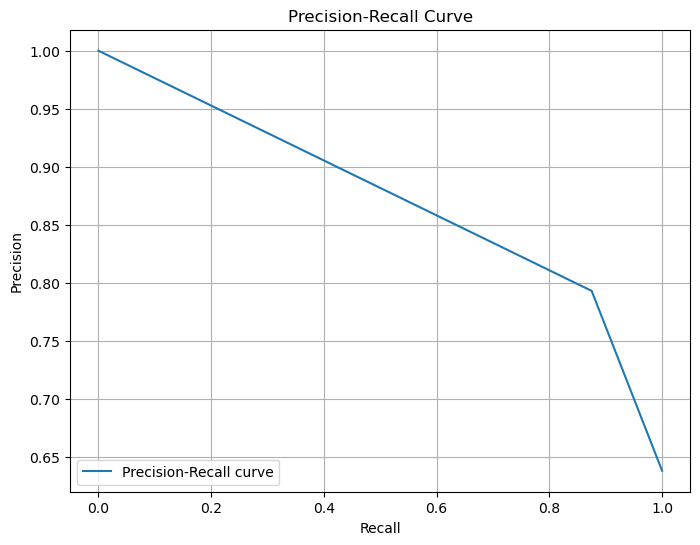

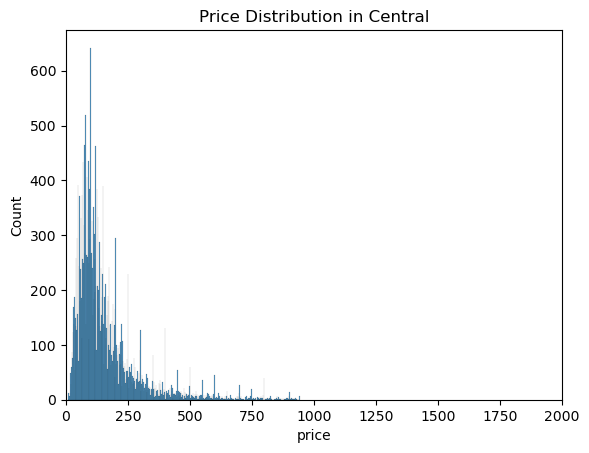

Accuracy in Central: 0.8926343926343926


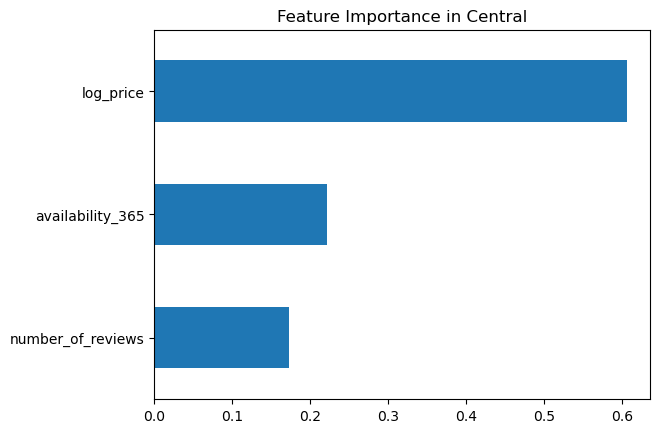

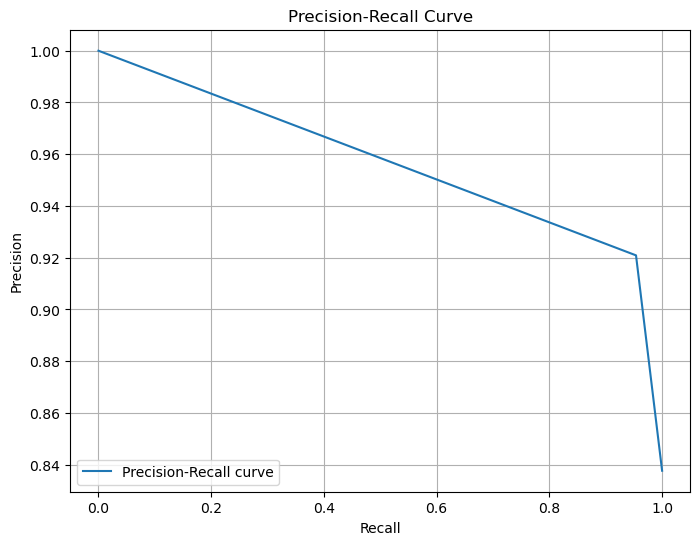

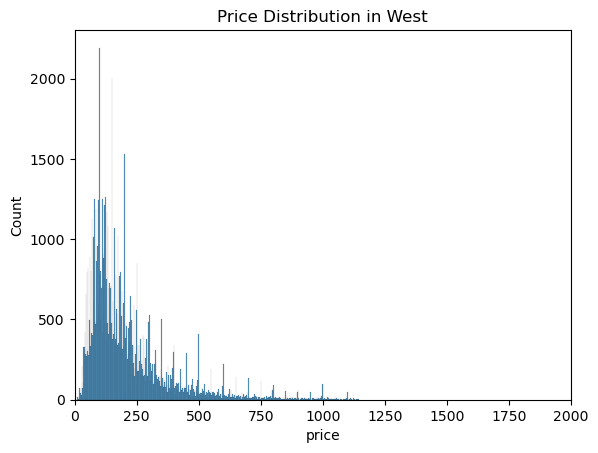

Accuracy in West: 0.8691117092866757


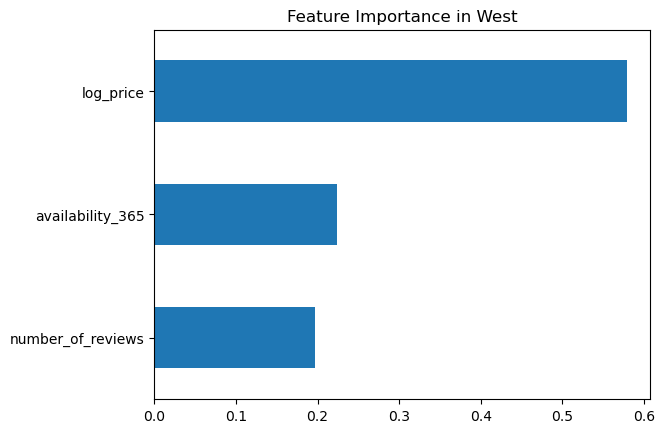

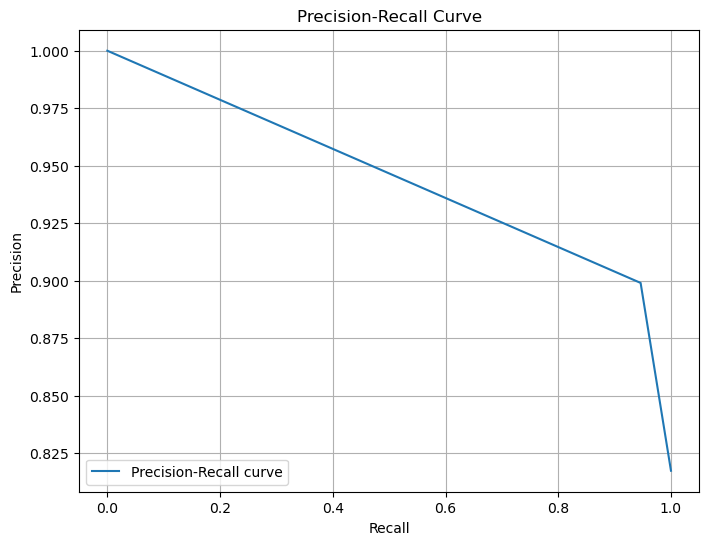

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

def analyze_airbnb_data(data, target_region):
    # Data Cleaning
    data = data.dropna(subset=['price', 'number_of_reviews', 'reviews_per_month'])
    data = data[data['price'] > 0]

    # EDA
    sns.histplot(data['price'], bins=500)
    plt.xlim(0, 2000)
    plt.title(f'Price Distribution in {target_region}')
    plt.show()

    # Feature Engineering
    data['log_price'] = np.log(data['price'])
    data['is_high_demand_season'] = data['availability_365'] < 100  # Example feature

    # Model Development
    X = data[['log_price', 'number_of_reviews', 'availability_365']]
    y = data['room_type'].apply(lambda x: 1 if x == 'Entire home/apt' else 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Validation & Testing
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy in {target_region}: {accuracy}")

    # Insight Generation
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values().plot(kind='barh')
    plt.title(f'Feature Importance in {target_region}')
    plt.show()
    
    # Assuming you have y_test and y_pred

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Assuming combined_df_east, combined_df_west, combined_df_central are already defined
analyze_airbnb_data(filtered_east,'East')

analyze_airbnb_data(filtered_central,'Central')
# Assuming combined_df_usa, combined_df_australia, combined_df_belgium, etc., are already defined
analyze_airbnb_data(filtered_west,'West')


## Comparative Analysis

Metrics for East:
  average_price: 175.60587398174502
  average_reviews: 32.33138660605001
  room_type_distribution: Entire home/apt    0.592376
Private room       0.390820
Shared room        0.011383
Hotel room         0.005421
Name: room_type, dtype: float64
  average_availability: 156.08317887742612
  average_rating: 4.773919915700741


Metrics for Central:
  average_price: 166.16823576313288
  average_reviews: 42.411639750537866
  room_type_distribution: Entire home/apt    0.800866
Private room       0.189820
Shared room        0.007789
Hotel room         0.001525
Name: room_type, dtype: float64
  average_availability: 171.12168087366214
  average_rating: 4.8180918325514295


Metrics for West:
  average_price: 226.2359383475805
  average_reviews: 42.232480672628164
  room_type_distribution: Entire home/apt    0.793197
Private room       0.195545
Shared room        0.009396
Hotel room         0.001861
Name: room_type, dtype: float64
  average_availability: 186.2138034842709
  averag

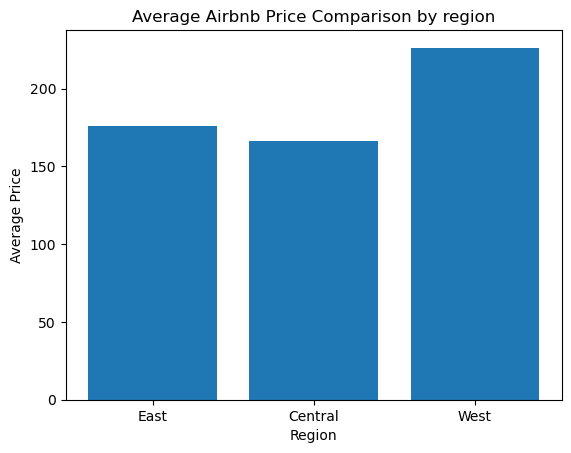

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

region_dataframes = {
    'East': filtered_east,
    'Central': filtered_central,
    'West': filtered_west
}

# Comparative Analysis Function
def comparative_analysis(dataframes):
    comparative_metrics = {}

    for region, df in dataframes.items():
        metrics = {}
        metrics['average_price'] = df['price'].mean()
        metrics['average_reviews'] = df['number_of_reviews'].mean()
        metrics['room_type_distribution'] = df['room_type'].value_counts(normalize=True)
        metrics['average_availability'] = df['availability_365'].mean()
        metrics['average_rating'] = df['rating'].mean()

        comparative_metrics[region] = metrics

    return comparative_metrics

# Performing the analysis
metrics = comparative_analysis(region_dataframes)

# Displaying the results
for region, region_metrics in metrics.items():
    print(f"Metrics for {region}:")
    for metric, value in region_metrics.items():
        print(f"  {metric}: {value}")
    print("\n")

# Optionally, you can visualize some of these metrics
# For example, average prices across countries
average_prices = {region: metrics[region]['average_price'] for region in metrics}
plt.bar(average_prices.keys(), average_prices.values())
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title('Average Airbnb Price Comparison by region')
plt.show()


### 1. Price Comparison

Compare the average price of Airbnb listings in each country.

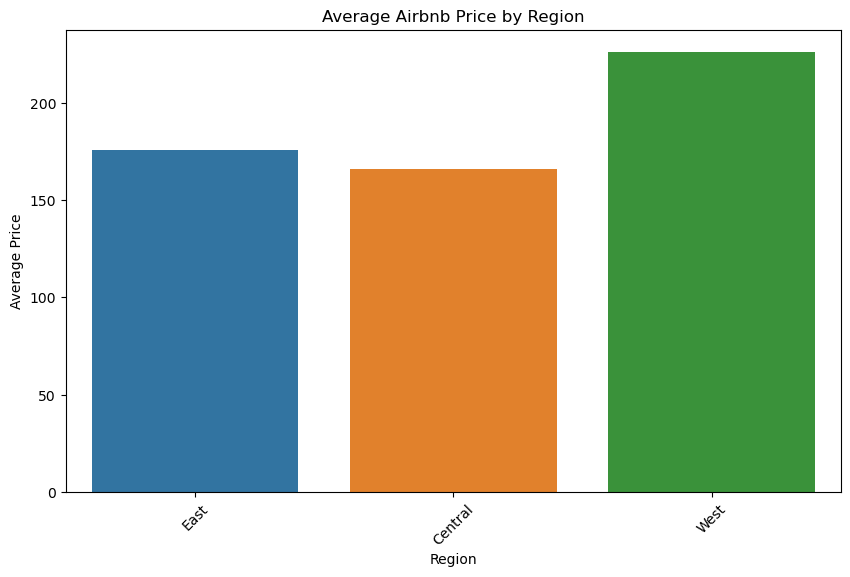

In [13]:
# Calculate average prices
average_prices = {region: df['price'].mean() for region, df in region_dataframes.items()}

# Visualize average prices
plt.figure(figsize=(10, 6))
sns.barplot(x=list(average_prices.keys()), y=list(average_prices.values()))
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title('Average Airbnb Price by Region')
plt.xticks(rotation=45)
plt.show()


### 2. Room Type Distribution
Compare the distribution of room types across countries.

room_type  Entire home/apt  Hotel room  Private room  Shared room
state                                                            
IL               75.680253    0.485492     22.931015     0.903240
MS               75.767983    0.171723     23.774089     0.286205
OH               83.634312    0.000000     16.102333     0.263356
TX               82.703001    0.020037     16.355257     0.921705


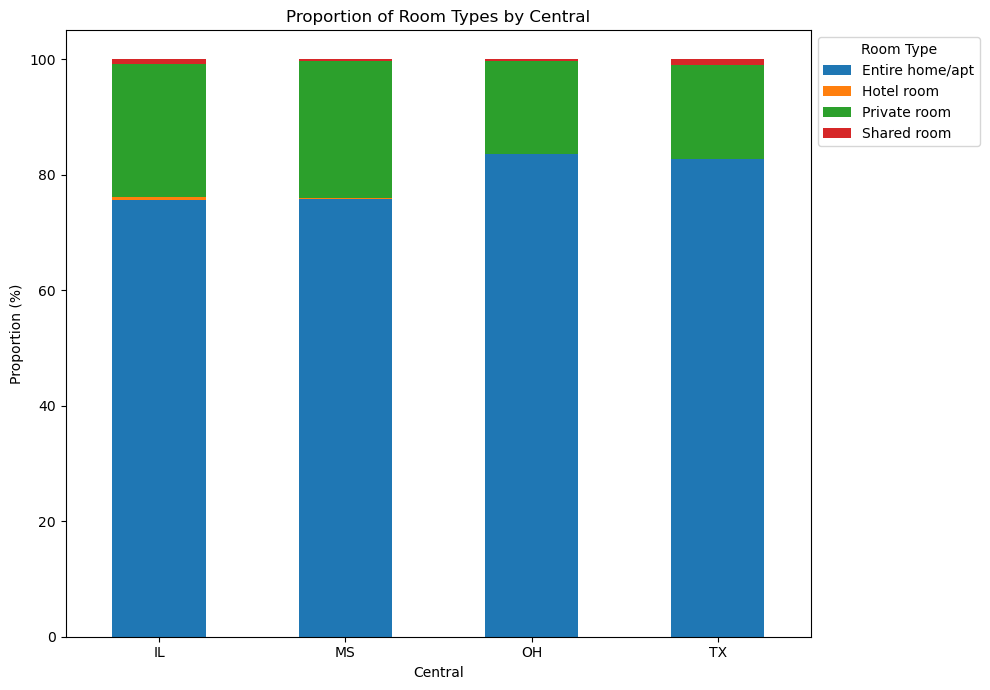

room_type  Entire home/apt  Hotel room  Private room  Shared room
state                                                            
DC               76.130838    0.147341     22.675704     1.046118
MA               65.839333    0.208412     33.516484     0.435771
NJ               63.411458    0.065104     36.263021     0.260417
NY               52.518041    0.685688     45.383805     1.412466
RI               81.978495    0.451613     17.505376     0.064516


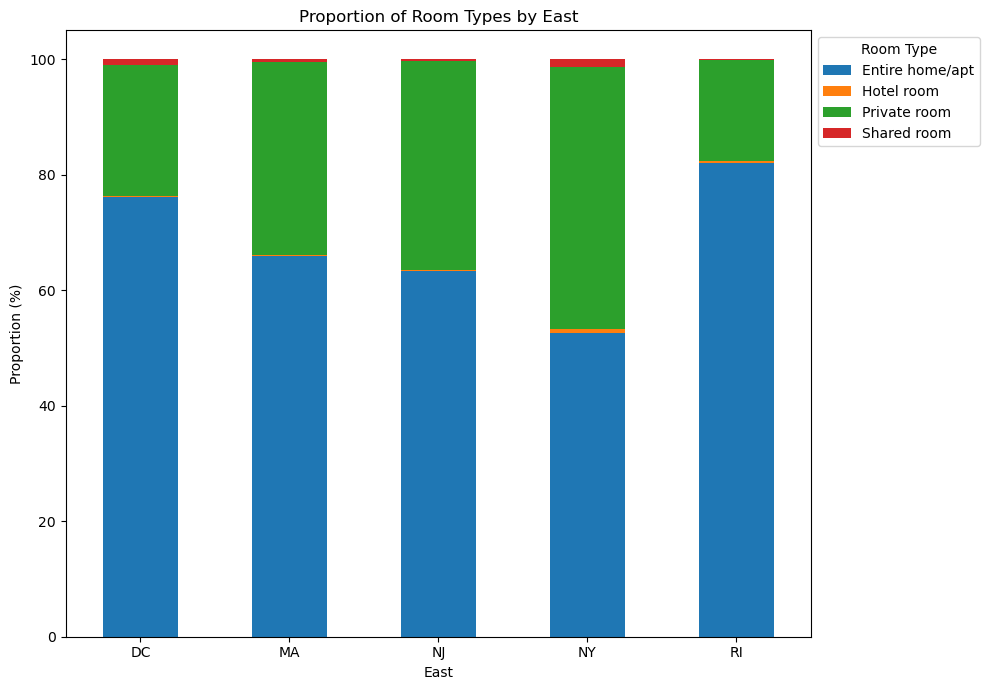

room_type  Entire home/apt  Hotel room  Private room  Shared room
state                                                            
CA               73.727088    0.190383     24.662770     1.419759
CO               85.179186    0.121482     14.091921     0.607410
H                89.048507    0.226182     10.590824     0.134487
WA               83.940542    0.000000     15.782571     0.276887


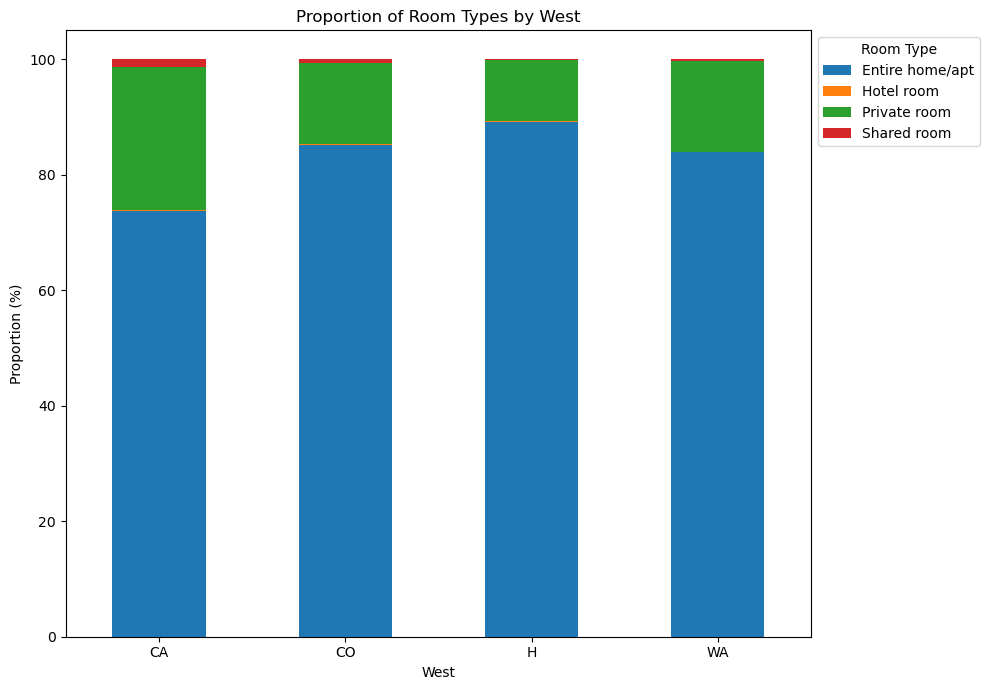

In [14]:
# # Room type distribution
# plt.figure(figsize=(12, 6))

# for region, df in region_dataframes.items():
#     room_types = df['room_type'].value_counts(normalize=True)
#     sns.barplot(x=room_types.index, y=room_types.values, label=region)

# plt.xlabel('Room Type')
# plt.ylabel('Proportion')
# plt.title('Room Type Distribution by Region')
# plt.legend()
# plt.show()


# Room type distribution with proportions
def room_type_analysis(df, region):
    room_type_props = (
        df.groupby('state')['room_type'].value_counts(normalize=True).unstack().fillna(0)
    ) * 100  # Calculate percentages

    print(room_type_props)

    room_type_props.plot(kind='bar', stacked=True, figsize=(10, 7))


    # Set labels and title
    plt.xlabel(f'{region}')
    plt.ylabel('Proportion (%)')
    plt.title(f'Proportion of Room Types by {region}')
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.legend(title='Room Type', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
    plt.tight_layout()

    plt.show()

room_type_analysis(filtered_central,"Central")
room_type_analysis(filtered_east,"East")
room_type_analysis(filtered_west,"West")

### 3. Review Patterns

Analyze and visualize the distribution of the number of reviews.

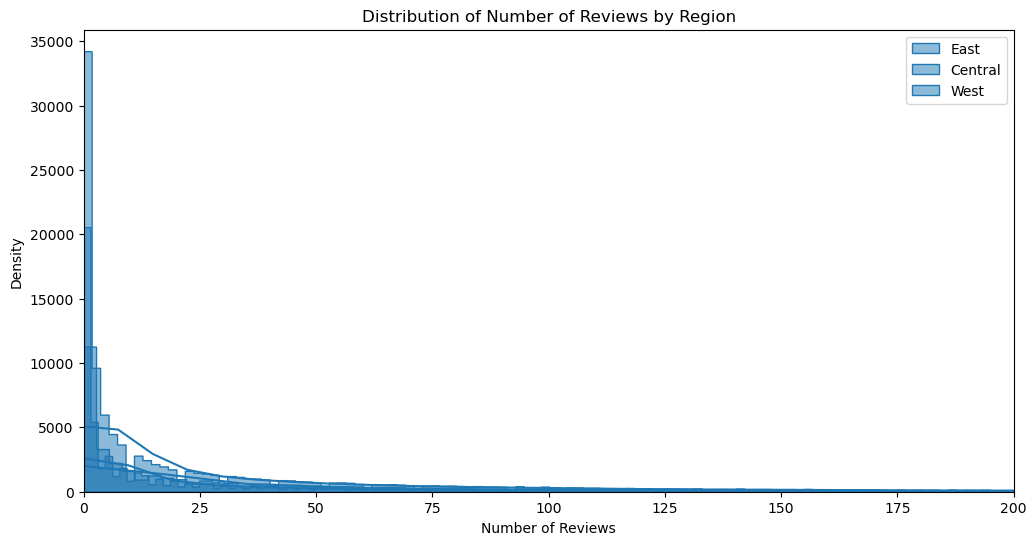

In [15]:
# Review patterns
plt.figure(figsize=(12, 6))

for region, df in region_dataframes.items():
    sns.histplot(df['number_of_reviews'], label=region, kde=True, element='step')

plt.xlabel('Number of Reviews')
plt.ylabel('Density')
plt.title('Distribution of Number of Reviews by Region')
plt.xlim(0,200)
plt.legend()
plt.show()


### 4. Availability Trends

Visualize the availability trends across countries.

In [16]:
import folium
from folium.plugins import HeatMap

def plot_heatmap(df):
    # Filter out listings with missing or zero values in price, latitude, and longitude
    df_filtered = df[df['price'] > 0].dropna(subset=['latitude', 'longitude'])

    # Create a base map
    base_map = folium.Map([df_filtered['latitude'].mean(), df_filtered['longitude'].mean()], zoom_start=10)

    # Add a heat layer
    HeatMap(data=df_filtered[['latitude', 'longitude', 'price']].values.tolist(), radius=8, max_zoom=13).add_to(base_map)

    return base_map


combined_df_usa = pd.concat([filtered_east,filtered_central,filtered_west],ignore_index=True)

plot_heatmap(combined_df_usa)



### 5. Calculate correlation matrix


Index(['id', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'city', 'state', 'is_canceled',
       'listing_name', 'rating', 'unit_type', 'no_of_beds', 'no_of_baths',
       'z_score'],
      dtype='object')


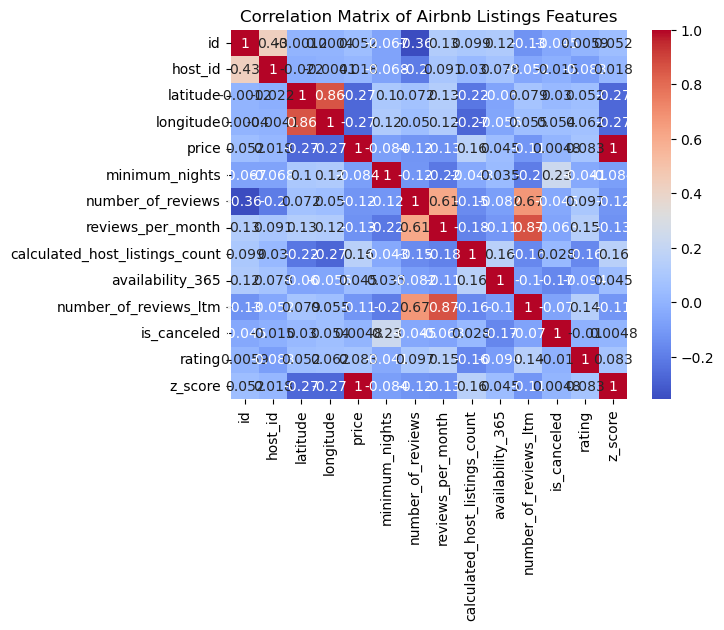

In [17]:
# Calculate correlation matrix
print(df.columns)
corr_matrix = df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Airbnb Listings Features')
plt.show()


### Data Acquisition & Cleaning

This step involves loading the data and performing necessary cleaning operations like handling missing values and ensuring data consistency.



EDA for East


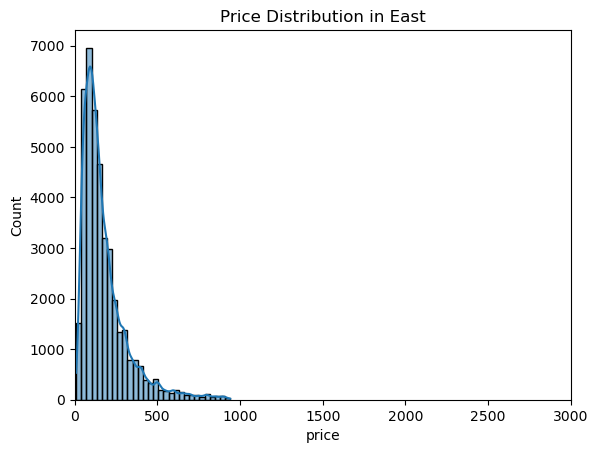

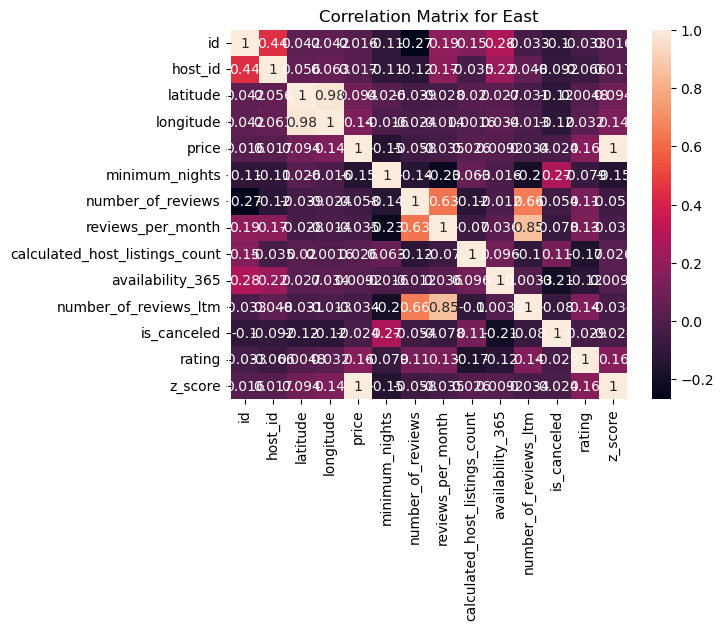

EDA for Central


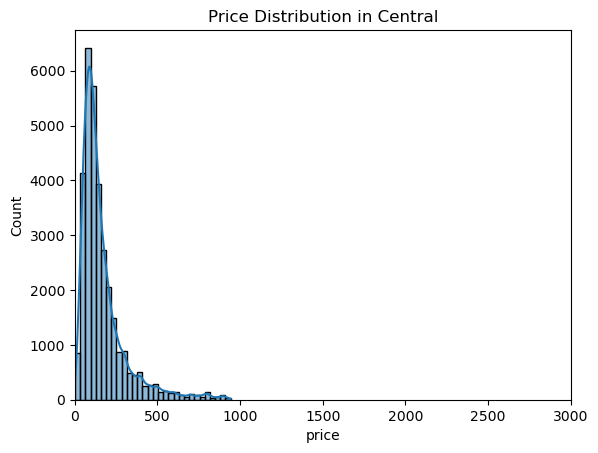

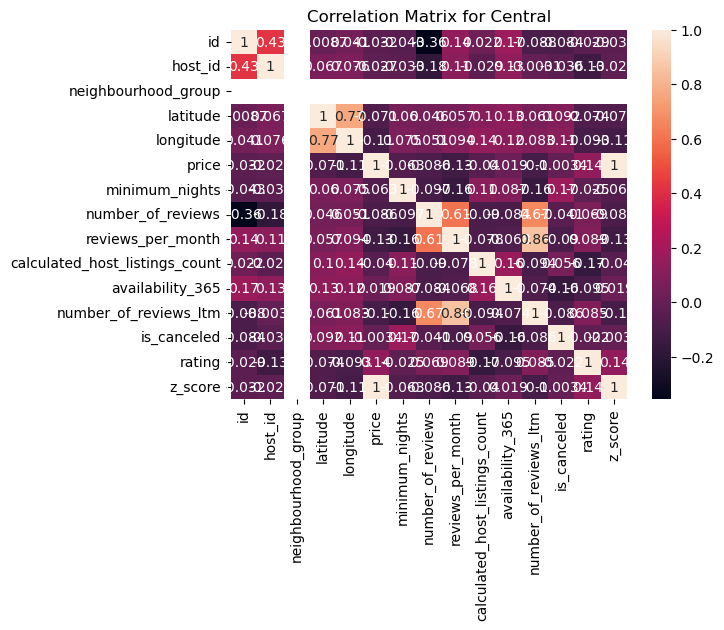

EDA for West


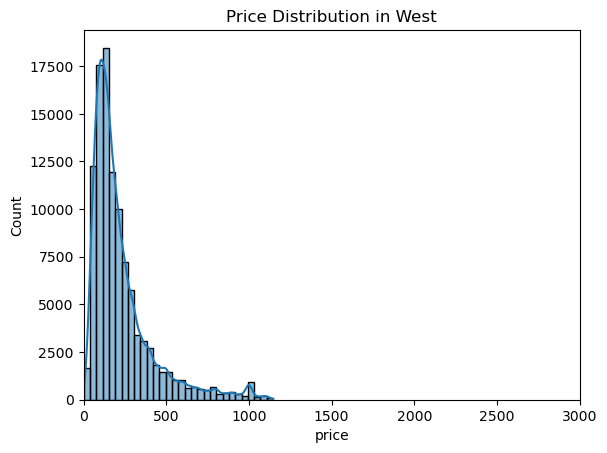

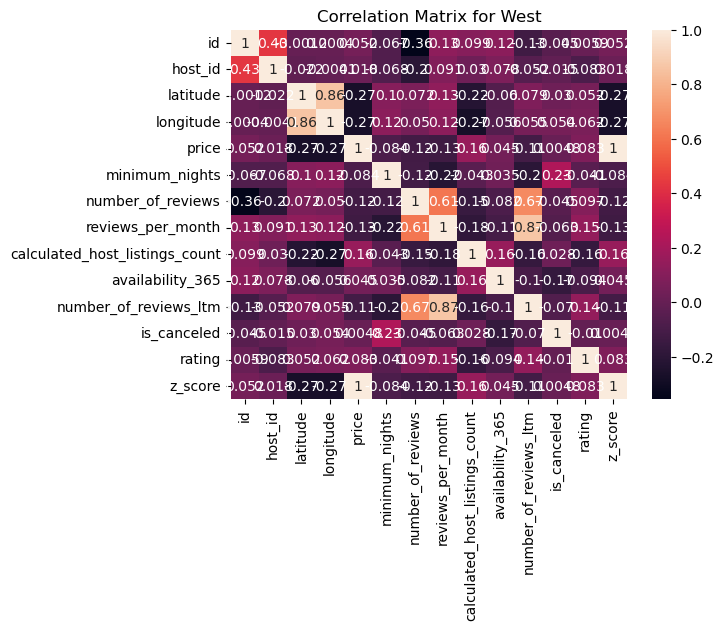

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
def exploratory_data_analysis(dataframes):
    for region, df in dataframes.items():
        print(f"EDA for {region}")
        # Price distribution
        sns.histplot(df['price'], bins=30, kde=True)
        plt.xlim(0,3000)
        plt.title(f'Price Distribution in {region}')
        plt.show()

        # Correlation matrix
        corr = df.corr()
        sns.heatmap(corr, annot=True)
        plt.title(f'Correlation Matrix for {region}')
        plt.show()

exploratory_data_analysis(region_dataframes)


EDA for East


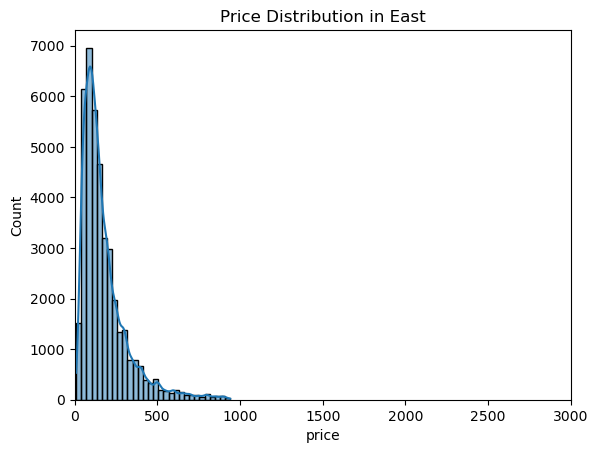

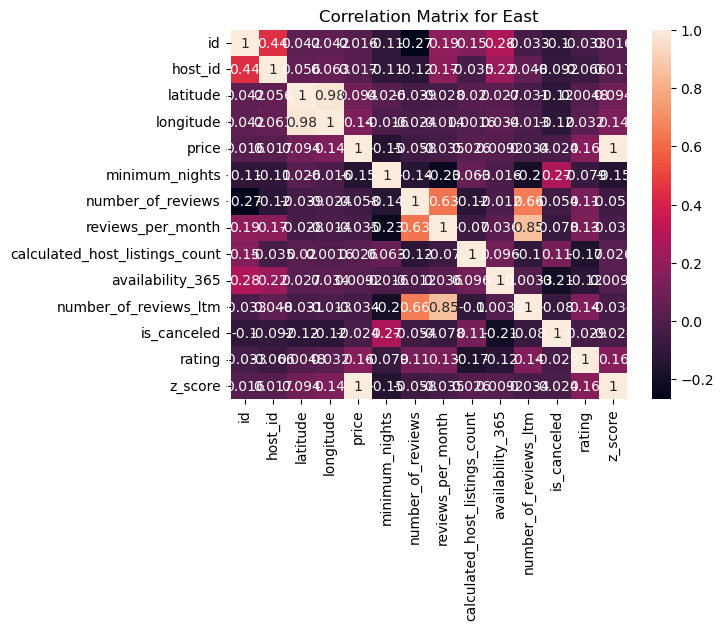

EDA for Central


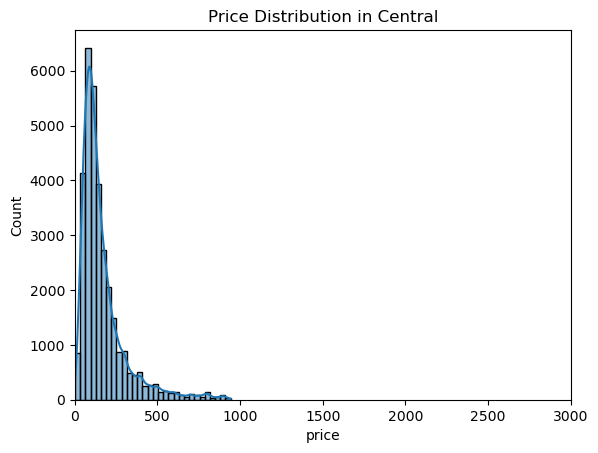

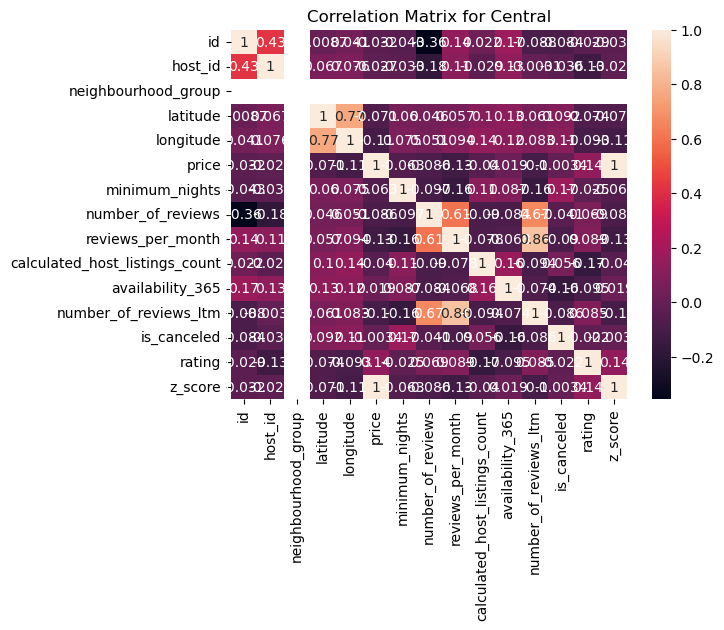

EDA for West


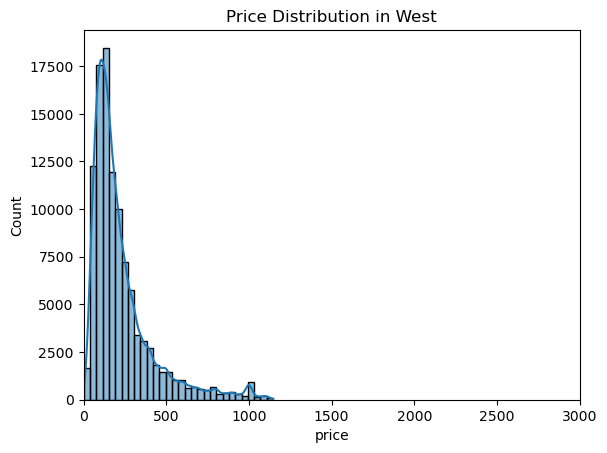

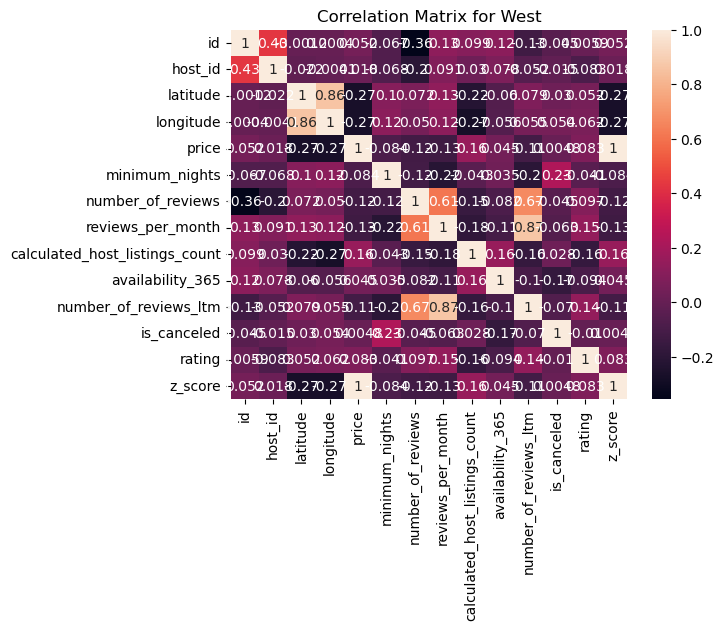

In [19]:

region_dataframes = {
   'East': filtered_east,
    'Central': filtered_central,
    'West': filtered_west
}


# Perform EDA
exploratory_data_analysis(region_dataframes)

# # Feature Engineering
# region_dataframes = feature_engineering(region_dataframes)

# # Model Development
# model_development(region_dataframes)


In [20]:
# Feature Engineering
def feature_engineering(dataframes):
    for region, df in dataframes.items():
        # Example: Creating a feature for price per review
        df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)
        dataframes[region] = df
    return dataframes

region_dataframes = feature_engineering(region_dataframes)


/var/folders/9q/blxc_lsn4jx36jwwb41zb6ch0000gn/T/ipykernel_2407/3329364254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)
/var/folders/9q/blxc_lsn4jx36jwwb41zb6ch0000gn/T/ipykernel_2407/3329364254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)
/var/folders/9q/blxc_lsn4jx36jwwb41zb6ch0000gn/T/ipykernel_2407/3329364254.py:5: SettingWithCopyWarning: 
A value is try

### Model Training and Results

Accuracy in East: 0.986874386653582


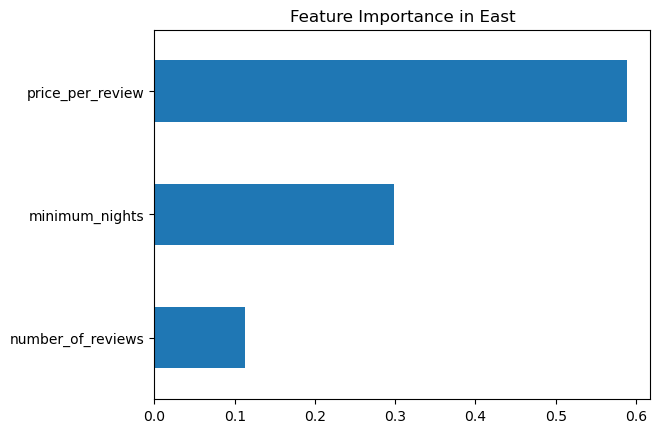

East - Model MSE: 0.013125613346418057
Accuracy in Central: 0.9927936215884698


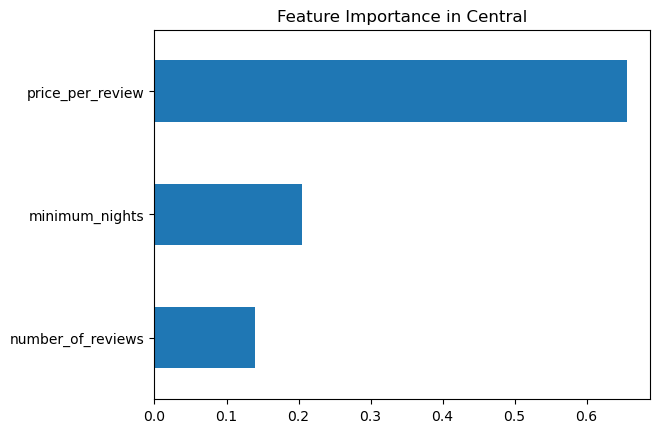

Central - Model MSE: 0.007206378411530205
Accuracy in West: 0.9853168108487257


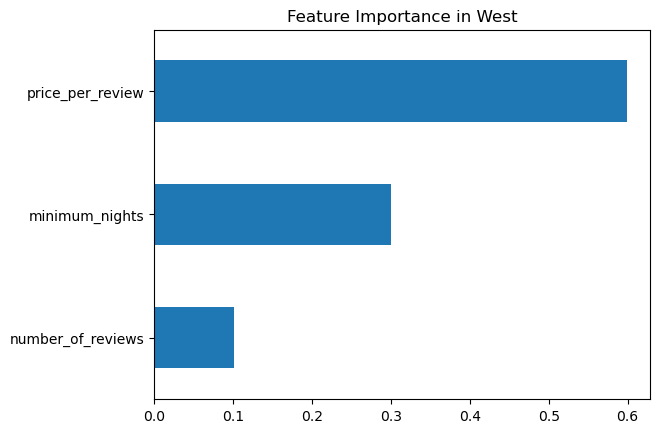

West - Model MSE: 0.014683189151274258


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Model Development
def model_development(dataframes):
    for region, df in dataframes.items():
        df = df.dropna(subset=['number_of_reviews', 'price_per_review','minimum_nights'])
        X = df[['number_of_reviews','price_per_review','minimum_nights']]  # Example features
        y = df['is_canceled']  # Target variable

        # Splitting the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Linear Regression Model
        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        # Predicting and evaluating the model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy in {region}: {accuracy}")

        # Insight Generation
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances.sort_values().plot(kind='barh')
        plt.title(f'Feature Importance in {region}')
        plt.show()

        # coefficients = model.coef_

        # Feature names (assuming your features are 'number_of_reviews' and 'minimum_nights')
        # feature_names = ['Number of Reviews','price_per_review','Minimum Nights']

        # # Bar plot for coefficients (absolute values for better visualization)
        # plt.figure(figsize=(8, 6))
        # plt.bar(feature_names, coefficients)  # Use absolute values for visualization
        # plt.xlabel('Features')
        # plt.ylabel('Coefficient (Absolute Value)')
        # plt.title(f'Coefficients - Feature Contribution to Price in region {region}')
        # plt.grid(True)
        # plt.show()
        
        print(f"{region} - Model MSE: {mse}")

model_development(region_dataframes)


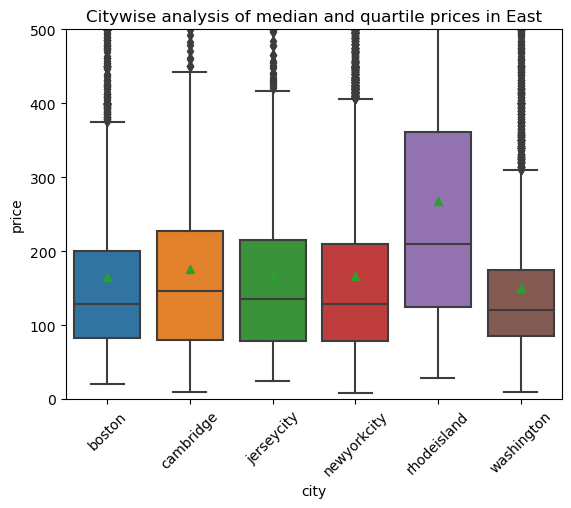

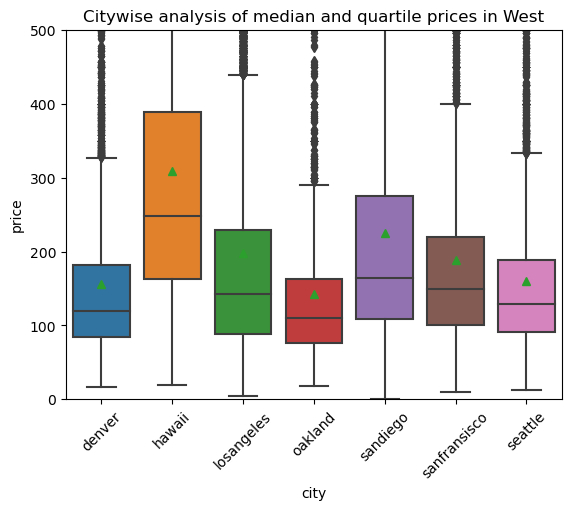

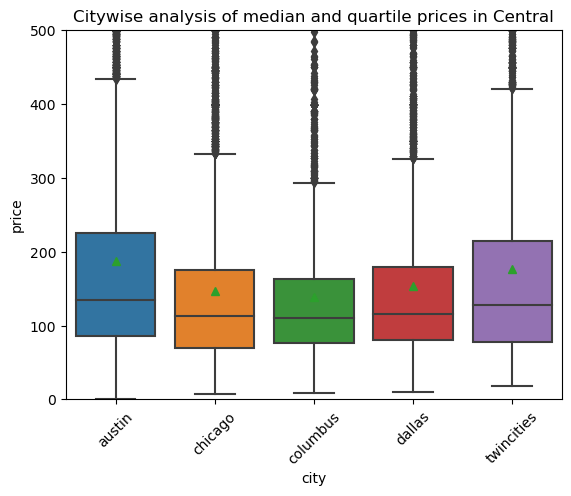

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def analyze_price_by_city(df,region):
    top_n_hoods = df['city'].value_counts()

    # Filter data for top neighbourhoods

    filtered_df = df[df['city'].isin(top_n_hoods.index)]

    # Create boxplot

    sns.boxplot(x="city", y="price", showmeans=True, data=filtered_df)

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylim(0,500)
    plt.title(f'Citywise analysis of median and quartile prices in {region}')
    plt.show()


analyze_price_by_city(filtered_east,"East")
analyze_price_by_city(filtered_west,"West")
analyze_price_by_city(filtered_central,"Central")

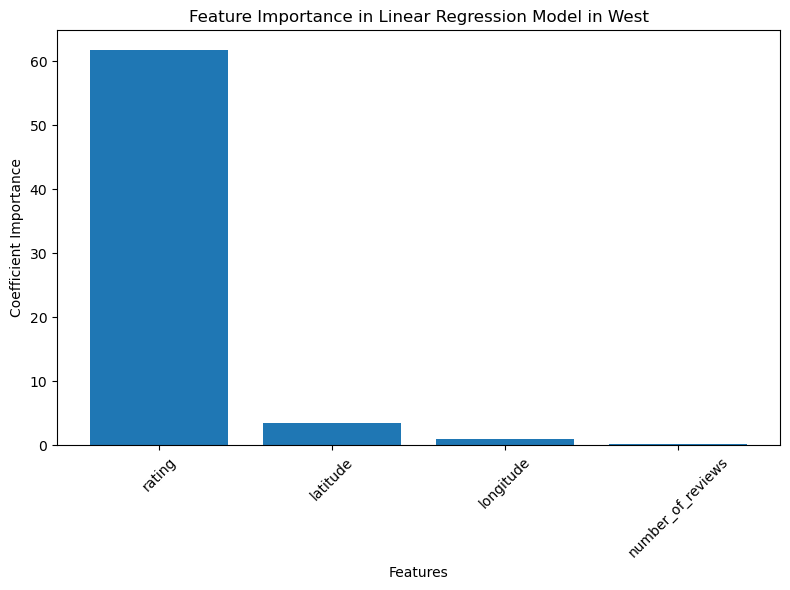

West: Accuracy: 97.1032


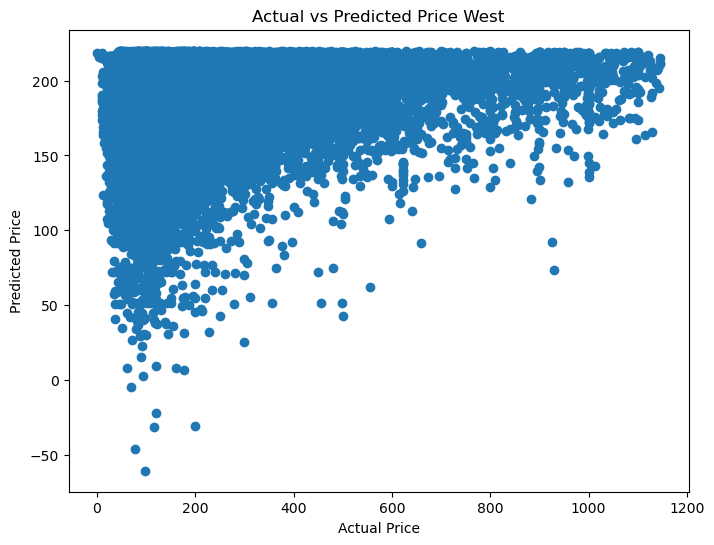

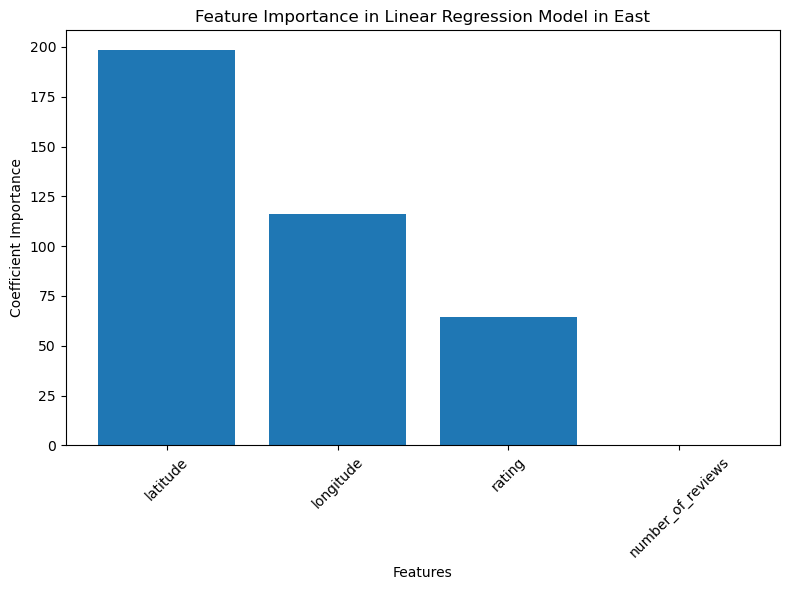

East: Accuracy: 80.3485


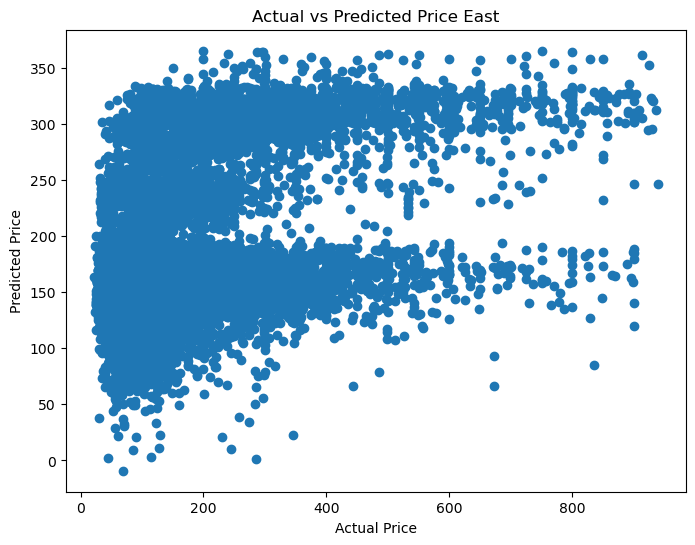

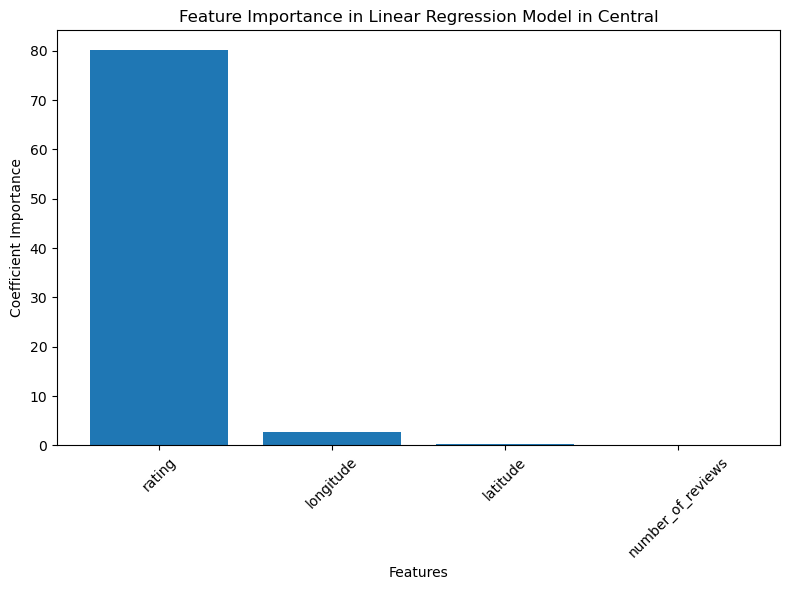

Central: Accuracy: 96.0005


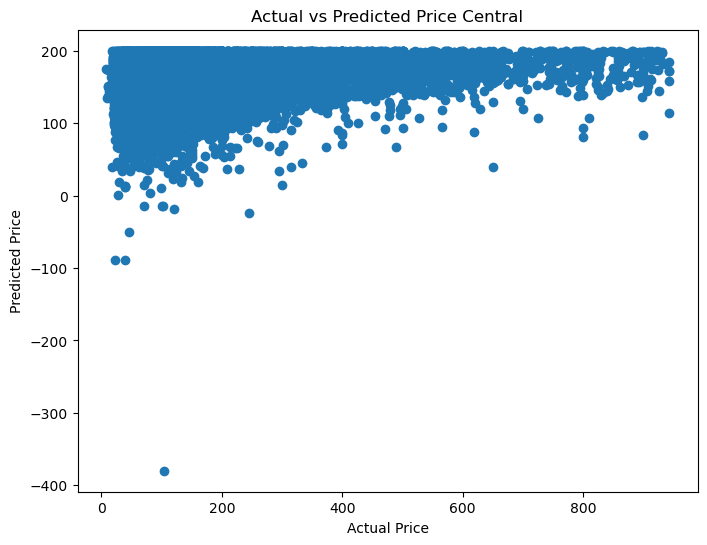

In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score


def linear_regression_model(df,region):

    # Select the features (predictors) and target variable
    features = ['latitude', 'longitude', 'number_of_reviews', 'rating']
    target = 'price'
    df = df.dropna(subset=features)
    df = df.dropna(subset=target)
    

    # Create the linear regression model
    model = LinearRegression()

    # Train the model on your data
    model.fit(df[features], df[target])

# Feature importances (if available in your linear regression model)
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)  # Get absolute coefficient values
        feature_names = features  # Assuming feature names match column names

        # Sort features by importance
        sorted_idx = importance.argsort()[::-1]
        importance = importance[sorted_idx]
        feature_names = np.array(feature_names)[sorted_idx]

        # Plot feature importance
        plt.figure(figsize=(8, 6))
        plt.bar(feature_names, importance)
        plt.xlabel('Features')
        plt.ylabel('Coefficient Importance')
        plt.title(f'Feature Importance in Linear Regression Model in {region}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Make predictions
    predictions = model.predict(df[features])

    # # Calculate mean squared error (MSE)
    # mse = np.mean((predictions - df[target])**2)

    # Calculate R-squared (accuracy metric for linear regression)
    r2 = r2_score(df[target], predictions)

    # Print model evaluation metrics
    # print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"{region}: Accuracy: {(1-r2)*100:.4f}")

    # Plot actual vs predicted price (optional)
    plt.figure(figsize=(8, 6))
    plt.scatter(df[target], predictions)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Price {region}')
    plt.show()


linear_regression_model(filtered_west,'West')
linear_regression_model(filtered_east,'East')
linear_regression_model(filtered_central,'Central')

In [24]:
# Example: Identifying high-demand areas
def high_demand_localities(dataframes):
    for region, df in dataframes.items():
        # Assuming 'neighbourhood' or similar column exists
        popular_areas = df['neighbourhood'].value_counts().head()
        print(f"{region} - Top 5 popular areas:\n{popular_areas}\n")

high_demand_localities(region_dataframes)



East - Top 5 popular areas:
Bedford-Stuyvesant    2782
Williamsburg          2301
Midtown               2108
Harlem                1832
Bushwick              1619
Name: neighbourhood, dtype: int64

Central - Top 5 popular areas:
Hennepin       2778
78704          2191
78702          1768
District 2     1531
District 14    1222
Name: neighbourhood, dtype: int64

West - Top 5 popular areas:
Primary Urban Center    6756
Lahaina                 4670
Kihei-Makena            4360
North Kona              3734
North Shore Kauai       2174
Name: neighbourhood, dtype: int64

